In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import joblib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [11]:
# read preprocessed data
data = pd.read_csv("Data/prepro_mergerdata.csv")

# rename first column to number
data = data.rename(columns={'Unnamed: 0': 'number'})
data

,number,date_completion,bidders_name,date_completion_assumed,date_last_status_update,status,bidders_industry,id,comments,targets_industry,...,targets_country,type,targets_name,bidders_country,sentences,cleaned_sentences,stemmed_sentences,lemmatized_sentences,pos_tagged_sentences,dependency_parsed_sentences
0,17,2014-07-31,['jaya hind investments pvt ltd'],NaN,NaN,Completed,['6499'],1907056319,2014-08-01: it was announced that on 31/07/14 ...,['2910'],...,['IN'],Acquisition 3.188%,['force motors ltd'],['IN'],['2014-08-01: it was announced that on 31/07/1...,['20140801 it was announced that on 310714 jay...,['20140801 it wa announc that on 310714 jaya h...,['20140801 it be announce that on 310714 jaya ...,"[[('20140801', 'CD'), ('it', 'PRP'), ('was', '...","[[('20140801', 'npadvmod', 'announced'), ('it'..."
1,162,2022-07-22,"['cwb automotive electronics co., ltd']",NaN,NaN,Completed,['2931'],1943340721,2022-04-27: it was announced that CWB Automoti...,['2561'],...,['CN'],Acquisition increased from 100% to 100%,"['yueqing guanghe surface treatment co., ltd']",['CN'],['2022-04-27: it was announced that CWB Automo...,['20220427 it was announced that cwb automotiv...,['20220427 it wa announc that cwb automot elec...,['20220427 it be announce that cwb automotive ...,"[[('20220427', 'CD'), ('it', 'PRP'), ('was', '...","[[('20220427', 'npadvmod', 'announced'), ('it'..."
2,238,NaN,"['beijing bdstar navigation co., ltd']",2021-09-16,NaN,Completed Assumed,['2651'],1943132402,2019-09-16: it was announced that Beijing BDSt...,['4669'],...,['CN'],Acquisition increased from 80% to 90%,['beijing beidou xingtong positioning technolo...,['CN'],['2019-09-16: it was announced that Beijing BD...,['20190916 it was announced that beijing bdsta...,['20190916 it wa announc that beij bdstar navi...,['20190916 it be announce that beijing bdstar ...,"[[('20190916', 'CD'), ('it', 'PRP'), ('was', '...","[[('20190916', 'npadvmod', 'announced'), ('it'..."
3,259,2015-06-02,"['patec precision industry co., ltd']",NaN,NaN,Completed,['2932'],1907102483,2015-06-02: it was announced that Patec Precis...,['2932'],...,['SG'],Acquisition increased from 100% to 100%,['patec pte ltd'],['KY'],['2015-06-02: it was announced that Patec Prec...,['20150602 it was announced that patec precisi...,['20150602 it wa announc that patec precis ind...,['20150602 it be announce that patec precision...,"[[('20150602', 'CD'), ('it', 'PRP'), ('was', '...","[[('20150602', 'npadvmod', 'announced'), ('it'..."
4,300,NaN,['china automotive holdings ltd'],NaN,2021-01-27,Withdrawn,['4519'],1941252521,2019-04-23: it was announced that Sprintex Ltd...,['2931'],...,['AU'],Acquisition unknown stake %,['sprintex ltd'],['CN'],['2019-04-23: it was announced that Sprintex L...,['20190423 it was announced that sprintex ltd ...,['20190423 it wa announc that sprintex ltd a m...,['20190423 it be announce that sprintex ltd a ...,"[[('20190423', 'CD'), ('it', 'PRP'), ('was', '...","[[('20190423', 'npadvmod', 'announced'), ('it'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,824785,NaN,"['changzhou tenglong auto parts co., ltd']",2018-03-23,NaN,Completed Assumed,['2930'],1907148524,2016-03-23: it was announced that Changzhou Te...,['2932'],...,['CN'],Acquisition increased from 100% to 100%,"['xiamen dajun accurate industrial co., ltd']",['CN'],['2016-03-23: it was announced that Changzhou ...,['20160323 it was announced that changzhou ten...,['20160323 it wa announc that changzhou tenglo...,['20160323 it be announce that changzhou tengl...,"[[('20160323', 'CD'), ('it', 'PRP'), ('was', '...","[[('20160323', 'npadvmod', 'announced'), ('it'..."
3391,824819,2017-12-06,"['zhejiang tiantie industry co., ltd']",NaN,2017-12-08,Completed,['2219'],1943003558,2017-11-20: it was announced that Zhejiang Tia...,['2899'],...,['CN'],Acquisition 51%,"['hebei lutong railway equipment co., ltd']",['CN'],['2017-11-20: it was announced that Zhejiang T...,['20171120 it was announc

In [12]:
lemmatized_text = data['lemmatized_sentences'].apply(lambda x: " ".join(eval(x)))

# feature engineering using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_text)

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [13]:
# feature engineering using BERT embeddings

# check if model exists in Models/ directory
try:
    # Try loading the model and embeddings
    model = joblib.load('Models/bert_model.pkl')
    embeddings_df = pd.read_csv("Data/embeddings.csv")
    print("Model and embeddings found.")
    print("Loaded embeddings:\n", embeddings_df.head())
except (FileNotFoundError, EOFError):  # Catch specific errors for missing files
    print("Model or embeddings not found. Generating new ones...")

    model = SentenceTransformer('all-MiniLM-L6-v2')

    sentence_embeddings = model.encode(lemmatized_text, show_progress_bar=True)

    embeddings_df = pd.DataFrame(sentence_embeddings)
    print("Generated embeddings:\n", embeddings_df.head())

    # Save the model
    joblib.dump(model, 'Models/bert_model.pkl')

    # Save the embeddings
    embeddings_df.to_csv("Data/embeddings.csv", index=False)

Model and embeddings found.
Loaded embeddings:
           0         1         2         3         4         5         6  \
0 -0.052809 -0.038020 -0.016260 -0.046810 -0.011117  0.087446  0.002803   
1 -0.032618 -0.028144  0.073250 -0.034925 -0.047233  0.008898  0.029912   
2 -0.063489 -0.015513  0.026258 -0.077508 -0.047614  0.030812  0.082038   
3 -0.061746 -0.042415  0.027517 -0.031067 -0.056502 -0.050850 -0.023097   
4 -0.081837 -0.020603 -0.000074 -0.044521 -0.049744  0.032372  0.012290   

          7         8         9  ...       374       375       376       377  \
0  0.106155  0.009057  0.017922  ... -0.042708  0.045368 -0.141863  0.019185   
1  0.020383 -0.031529 -0.017767  ... -0.050487  0.066955 -0.090817  0.009161   
2  0.059187 -0.019487  0.013194  ...  0.023294  0.097975 -0.032301 -0.066112   
3  0.056935  0.035830 -0.028737  ... -0.068408  0.022757 -0.101495 -0.092565   
4  0.102173 -0.036398  0.005273  ...  0.005733  0.064733 -0.078019 -0.015810   

        378       37

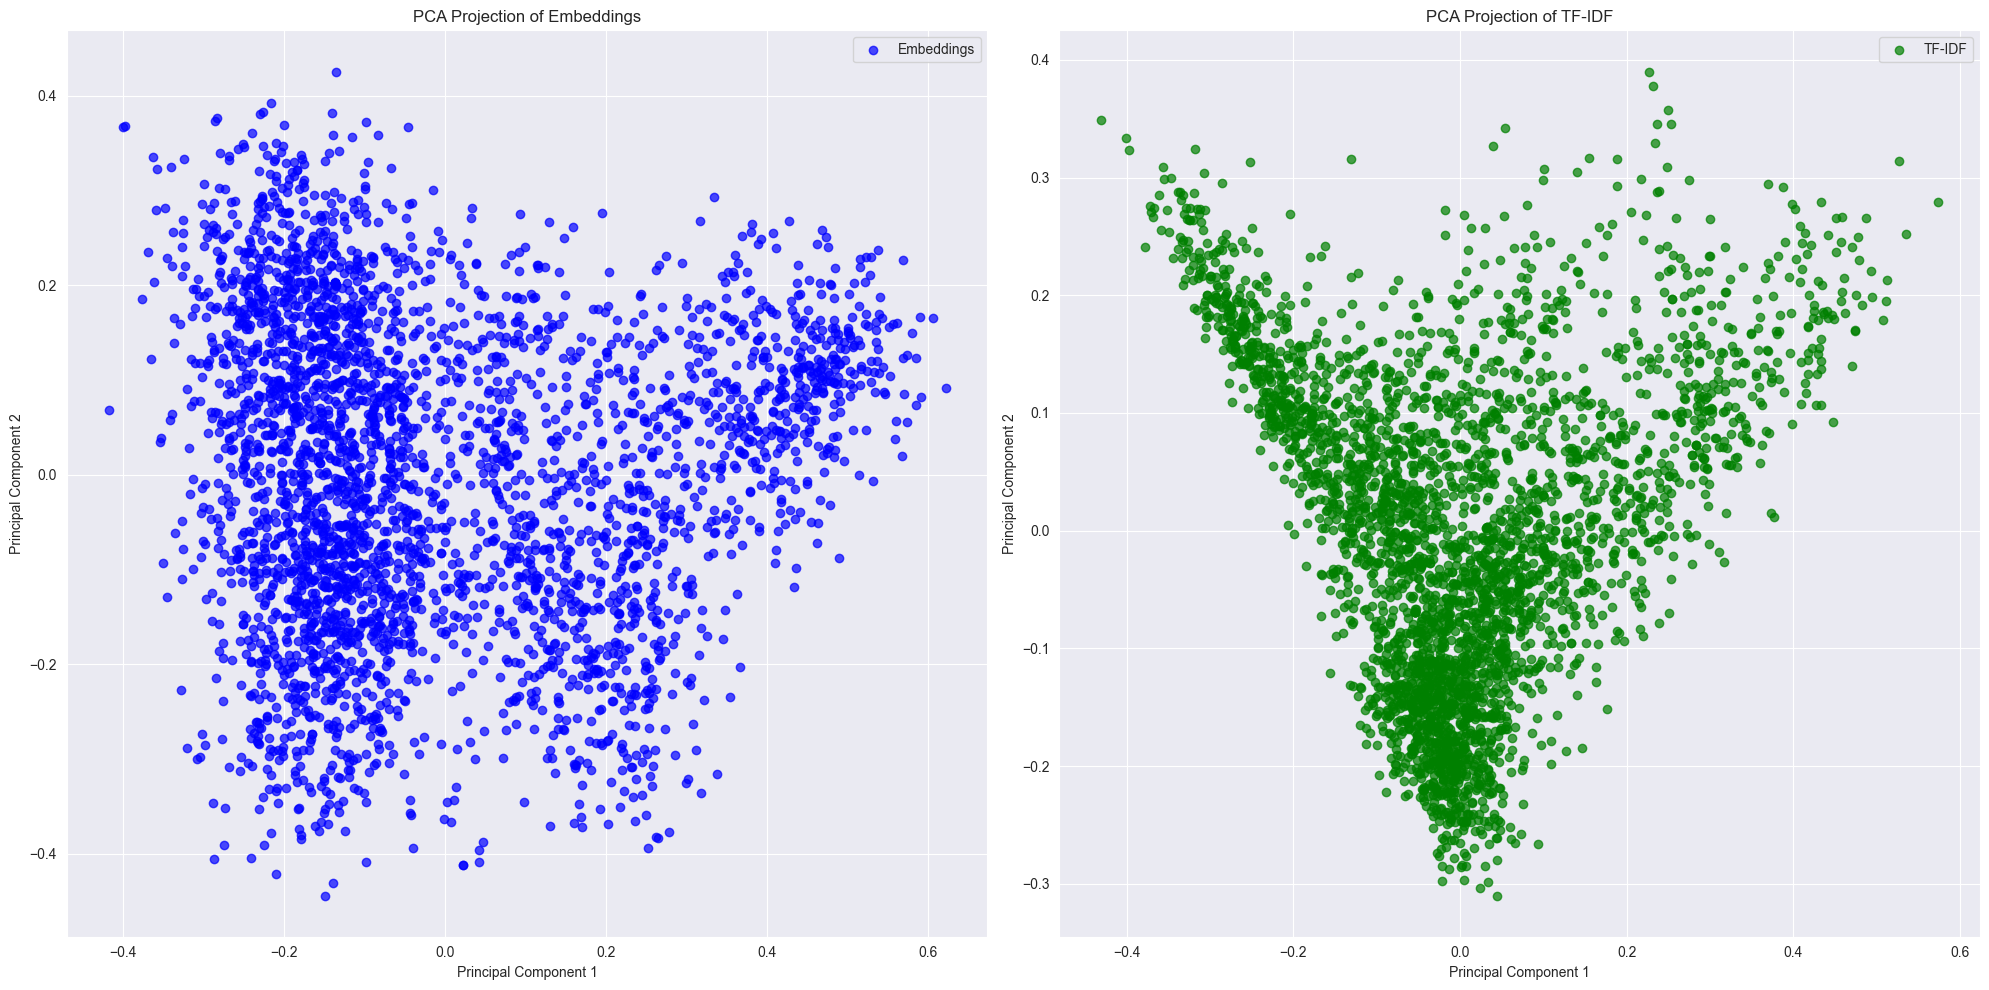

In [14]:
embeddings_features = embeddings_df.iloc[:, 2:]
tfidf_features = tfidf_df.iloc[:, 1:]

pca_embeddings = PCA(n_components=2)
pca_tfidf = PCA(n_components=2)

embeddings_2d = pca_embeddings.fit_transform(embeddings_features)
tfidf_2d = pca_tfidf.fit_transform(tfidf_features)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot embeddings
ax[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7, c='blue', label='Embeddings')
ax[0].set_title('PCA Projection of Embeddings')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')
ax[0].legend()

# Plot TF-IDF
ax[1].scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], alpha=0.7, c='green', label='TF-IDF')
ax[1].set_title('PCA Projection of TF-IDF')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')
ax[1].legend()

plt.tight_layout()
plt.show()

In [15]:
## t-SNE
sampled_embeddings_features = embeddings_features.iloc[:50, :]
sampled_tfidf_features = tfidf_features.iloc[:50, :]

tsne_embeddings = TSNE(n_components=2, random_state=42, perplexity=15, max_iter=500)
tsne_tfidf = TSNE(n_components=2, random_state=42, perplexity=15, max_iter=500)

embeddings_2d_tsne = tsne_embeddings.fit_transform(embeddings_features)
tfidf_2d_tsne = tsne_tfidf.fit_transform(tfidf_df)

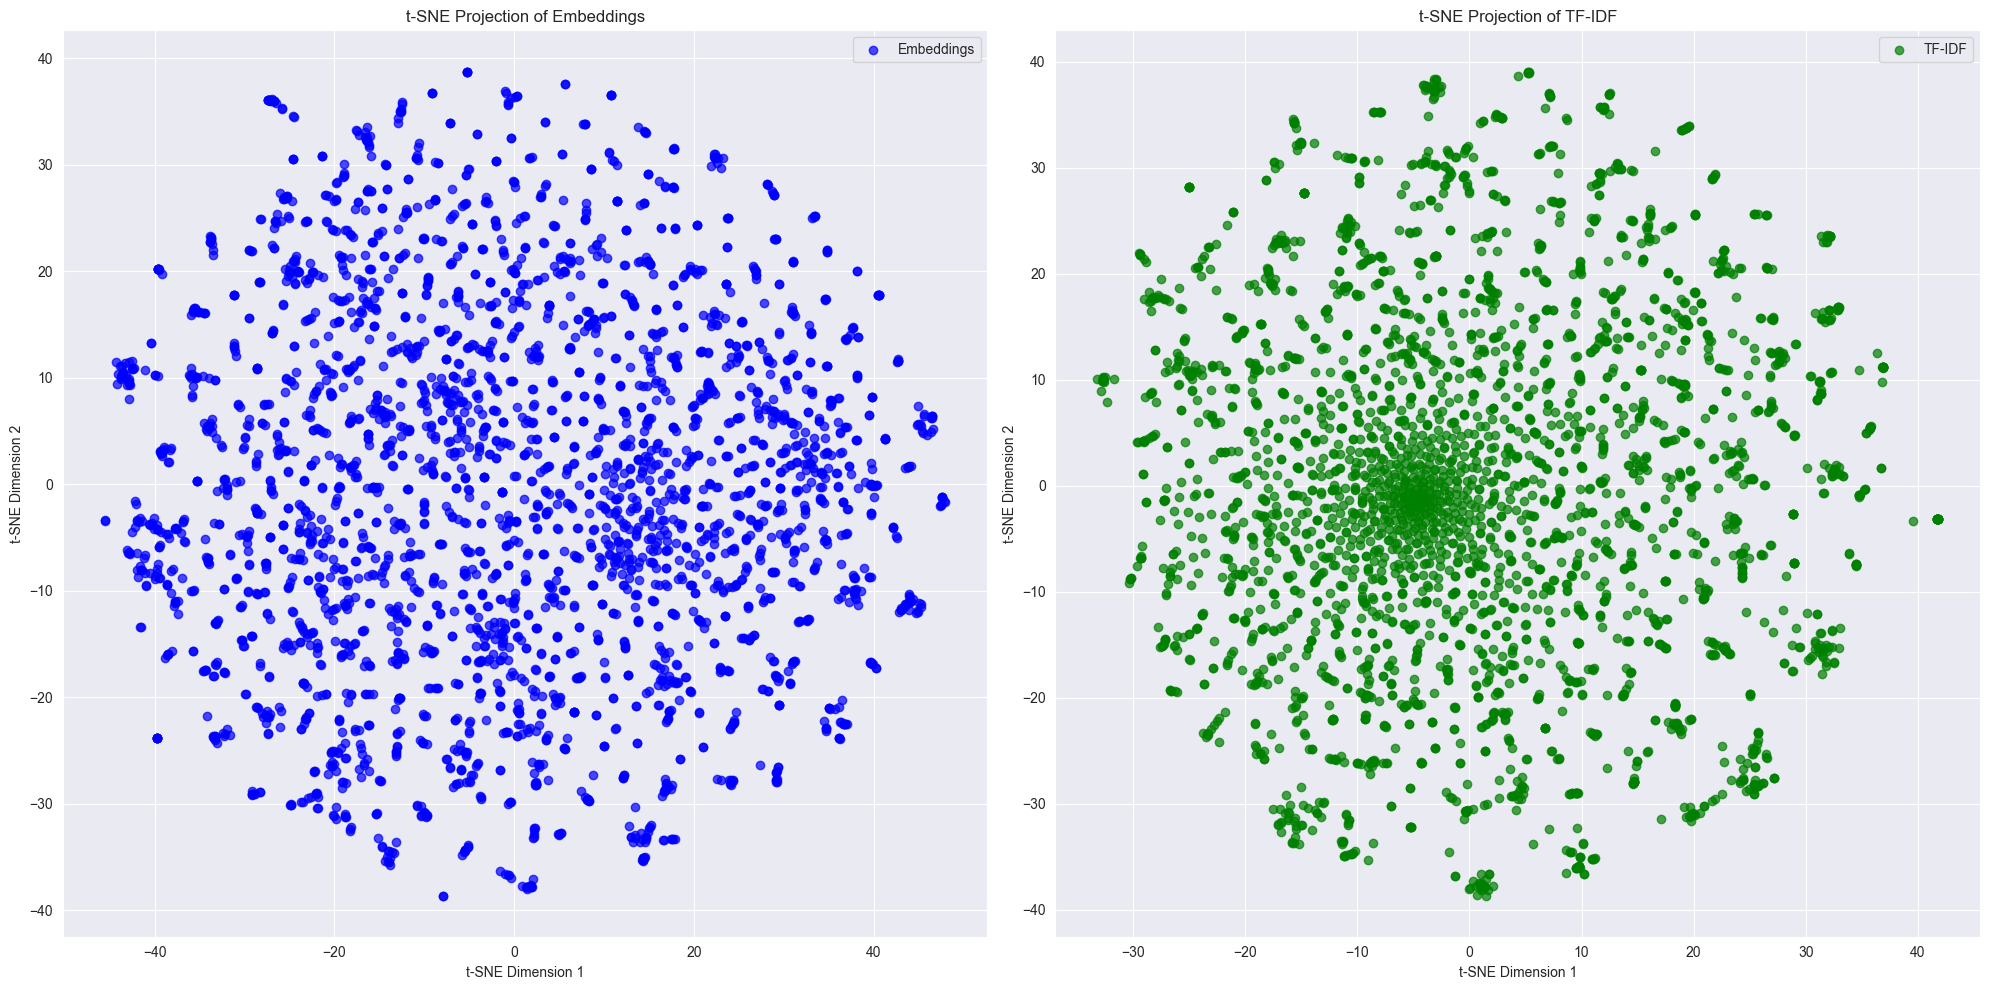

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], alpha=0.7, c='blue', label='Embeddings')
ax[0].set_title('t-SNE Projection of Embeddings')
ax[0].set_xlabel('t-SNE Dimension 1')
ax[0].set_ylabel('t-SNE Dimension 2')
ax[0].legend()

# Plot TF-IDF t-SNE
ax[1].scatter(tfidf_2d_tsne[:, 0], tfidf_2d_tsne[:, 1], alpha=0.7, c='green', label='TF-IDF')
ax[1].set_title('t-SNE Projection of TF-IDF')
ax[1].set_xlabel('t-SNE Dimension 1')
ax[1].set_ylabel('t-SNE Dimension 2')
ax[1].legend()

plt.tight_layout()
plt.show()